# Open Data Cube - Water Analysis Notebook 

**Description:** This Python notebook allows users to directly interact with an Open Data Cube to perform water classification. The following steps will allow users to connect to a data cube, define the analysis location and time period (extent of latitude/longitude and dates), and then run the Australian Water Observations from Space (WOFS) algorithm. 

The outputs of the WOFS algorithm include static and time series pixel-level water observations for any pixel. These results provide critical information for water management that will allow users to assess water cycle dynamics, historical water extent and the risk of floods and droughts.

This notebook is based on a CEOS notebook https://github.com/ceos-seo/data_cube_notebooks/blob/master/water_detection.ipynb 

The water classifier is based on Mueller, et al. (2015) "Water observations from space: Mapping surface water from 25 years of Landsat imagery across Australia." Remote Sensing of Environment. https://github.com/GeoscienceAustralia/eo-tools/blob/stable/eotools/water_classifier.py https://www.sciencedirect.com/science/article/pii/S0034425715301929

## Import libraries

In [1]:
# %matplotlib inline
%pylab notebook

from matplotlib import pyplot as plt
import ipywidgets as widgets

from datetime import datetime
import numpy as np
import gc
import warnings

import datacube
from datacube.storage import masking
import xarray as xr

Populating the interactive namespace from numpy and matplotlib


## Link to your Data Cube

In [2]:
from datacube import Datacube
dc = datacube.Datacube()

# Define functions

## Water Observations from Space (WOfS) Classifier 

In [3]:
def water_classifier(dataset_in):
    def _band_ratio(a, b):
        """
        Calculates a normalized ratio index
        """
        return (a - b) / (a + b)

    def _run_regression(band1, band2, band3, band4, band5, band7):
        """
        Water classifier. Regression analysis based on Australia training data.
        """

        # Compute normalized ratio indices
        ndi_52 = _band_ratio(band5, band2)
        ndi_43 = _band_ratio(band4, band3)
        ndi_72 = _band_ratio(band7, band2)

        #classified = np.ones(shape, dtype='uint8')

        classified = np.full(shape, no_data, dtype='uint8')

        # Start with the tree's left branch, finishing nodes as needed

        # Left branch
        r1 = ndi_52 <= -0.01

        r2 = band1 <= 2083.5
        classified[r1 & ~r2] = 0  #Node 3

        r3 = band7 <= 323.5
        _tmp = r1 & r2
        _tmp2 = _tmp & r3
        _tmp &= ~r3

        r4 = ndi_43 <= 0.61
        classified[_tmp2 & r4] = 1  #Node 6
        classified[_tmp2 & ~r4] = 0  #Node 7

        r5 = band1 <= 1400.5
        _tmp2 = _tmp & ~r5

        r6 = ndi_43 <= -0.01
        classified[_tmp2 & r6] = 1  #Node 10
        classified[_tmp2 & ~r6] = 0  #Node 11

        _tmp &= r5

        r7 = ndi_72 <= -0.23
        _tmp2 = _tmp & ~r7

        r8 = band1 <= 379
        classified[_tmp2 & r8] = 1  #Node 14
        classified[_tmp2 & ~r8] = 0  #Node 15

        _tmp &= r7

        r9 = ndi_43 <= 0.22
        classified[_tmp & r9] = 1  #Node 17
        _tmp &= ~r9

        r10 = band1 <= 473
        classified[_tmp & r10] = 1  #Node 19
        classified[_tmp & ~r10] = 0  #Node 20

        # Left branch complete; cleanup
        del r2, r3, r4, r5, r6, r7, r8, r9, r10
        gc.collect()

        # Right branch of regression tree
        r1 = ~r1

        r11 = ndi_52 <= 0.23
        _tmp = r1 & r11

        r12 = band1 <= 334.5
        _tmp2 = _tmp & ~r12
        classified[_tmp2] = 0  #Node 23

        _tmp &= r12

        r13 = ndi_43 <= 0.54
        _tmp2 = _tmp & ~r13
        classified[_tmp2] = 0  #Node 25

        _tmp &= r13

        r14 = ndi_52 <= 0.12
        _tmp2 = _tmp & r14
        classified[_tmp2] = 1  #Node 27

        _tmp &= ~r14

        r15 = band3 <= 364.5
        _tmp2 = _tmp & r15

        r16 = band1 <= 129.5
        classified[_tmp2 & r16] = 1  #Node 31
        classified[_tmp2 & ~r16] = 0  #Node 32

        _tmp &= ~r15

        r17 = band1 <= 300.5
        _tmp2 = _tmp & ~r17
        _tmp &= r17
        classified[_tmp] = 1  #Node 33
        classified[_tmp2] = 0  #Node 34

        _tmp = r1 & ~r11

        r18 = ndi_52 <= 0.34
        classified[_tmp & ~r18] = 0  #Node 36
        _tmp &= r18

        r19 = band1 <= 249.5
        classified[_tmp & ~r19] = 0  #Node 38
        _tmp &= r19

        r20 = ndi_43 <= 0.45
        classified[_tmp & ~r20] = 0  #Node 40
        _tmp &= r20

        r21 = band3 <= 364.5
        classified[_tmp & ~r21] = 0  #Node 42
        _tmp &= r21

        r22 = band1 <= 129.5
        classified[_tmp & r22] = 1  #Node 44
        classified[_tmp & ~r22] = 0  #Node 45

        # Completed regression tree

        return classified
    
    blue = dataset_in.blue
    green = dataset_in.green
    red = dataset_in.red
    nir = dataset_in.nir
    swir1 = dataset_in.swir1
    swir2 = dataset_in.swir2

    dtype = blue.values.dtype 
    shape = blue.values.shape

    no_data =-9999

    classified = _run_regression(blue.values, green.values, red.values, nir.values, swir1.values, swir2.values)

    classified_clean=classified.astype('float64')
    
    y = dataset_in.y
    x = dataset_in.x

    time = None
    coords = None
    dims = None

    time = dataset_in.time
    coords = [time, y, x]
    dims = ['time', 'y', 'x']

    data_array = xr.DataArray(classified_clean, coords=coords, dims=dims)

    dataset_out = xr.Dataset({'wofs': data_array}, coords={'time': time, 'y': y,'x': x})
    return dataset_out


## Retrieving Surface reflectance, Cloud Filtering and Cloud Masking

In [4]:
def load_combine_mask_discard(sensors, bands_of_interest, query, cloud_free_threshold):  
    sensor_clean = {}
    for sensor in sensors: #loop through specified sensors
        sensor_sr = dc.load(product= sensor+'_usgs_sr_scene',
                               measurements = bands_of_interest,group_by='solar_day', 
                               **query) 
        
        # if no data found for sensor skip it
        if not sensor_sr.data_vars:
            print('skipping %s' % sensor) 
            continue
        
        #retrieve the projection information before masking/sorting so we can add it back later
        crs = sensor_sr.crs
        affine = sensor_sr.affine
        
        #assign pq data variable
        sensor_pq= sensor_sr.pixel_qa
        
        # Convert No-Data values to NaNs
        sensor_sr = masking.mask_invalid_data(sensor_sr)
        
        #create cloud mask
        cloud_free = masking.make_mask(sensor_pq, cloud_shadow= 'no_cloud_shadow',cloud= 'no_cloud')
        
        del sensor_pq
        
        #discard data that does not meet the cloud_free_threshold
        masked_data = sensor_sr.where(cloud_free).dropna(dim='time', thresh=cloud_free_threshold*cloud_free.x.size*cloud_free.y.size)
        
        del sensor_sr
        
        #assign masked data to array
        sensor_clean[sensor] = masked_data
        
        del masked_data

        print('loaded %s' % sensor) 
    
    #combine sensors and sort by time
    sr_clean = xr.concat(sensor_clean.values(), 'time')
    del sensor_clean
    sr_clean = sr_clean.sortby('time')
        
    
    #apply projection information to resulting xarray
    sr_clean.attrs['crs'] = crs
    sr_clean.attrs['affine'] = affine
    return sr_clean

# Query and extract data from Data Cube

In [5]:
#Some example areas of interest
lacantan_bounds = {
    'x': (-91.1621, -91.0011),
    'y': (15.9977, 16.1652)
}

sisal_bounds = {
    'x': (-90.0688, -89.9758),
    'y': (21.1057, 21.1975)
}

lake_cuitzeo_bounds = {
    'x': (-101.3879, -101.1072),
    'y': (19.7894, 20.0734)
}

grande_de_santiago_river_bounds = {
    'x': (-105.4834, -105.3600),
    'y': (21.5759, 21.7016)
}

In [6]:
# Lets look at the grande de santiago river
aoi_bounds = grande_de_santiago_river_bounds

In [7]:
#Query is created
query = {'time': ('1987-01-01', '2018-01-01'),}
query['x'] = aoi_bounds['x']
query['y'] = aoi_bounds['y']
query['crs'] = 'EPSG:4326'
query['resolution'] = (-30, 30)
query['output_crs'] = 'EPSG:32616'

#The bands required for WOfS
bands_of_interest = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']

#set cloud free threshold
cloud_free_threshold = 0.10

#define Landsat sensors of interest
sensors = ['ls8','ls7','ls5'] 

In [8]:
#Load clean surface reflectance data from Data Cube
sr_clean = load_combine_mask_discard(sensors, bands_of_interest, query, cloud_free_threshold)

loaded ls8
loaded ls7
loaded ls5


# Classify water and calculate Water Observations from Space (WOfS)

## Use water classifier function

In [9]:
#Use water clasifier function created above
warnings.filterwarnings('ignore') #turn off warnings
water_class = water_classifier(sr_clean) #use function
warnings.filterwarnings('always') #turn on warnings

## Calculate and plot WOfS

In [10]:
total_water_obs = water_class.wofs.sum(dim='time')
sr_count = sr_clean.pixel_qa.count(dim='time')
wofs_percent = ((total_water_obs/sr_count)*100)

In [11]:
#Set up colour ramp details
wofs_cmap = mpl.colors.ListedColormap(['#000000', '#e38400', '#e3df00', '#62e300',
                                       '#00e384', '#00e3c8', '#00c5e3', '#0097e3', 
                                       '#005fe3', '#000fe3', '#5700e3'])
wofs_bounds = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
wofs_norm = mpl.colors.BoundaryNorm(wofs_bounds, wofs_cmap.N)

<IPython.core.display.Javascript object>


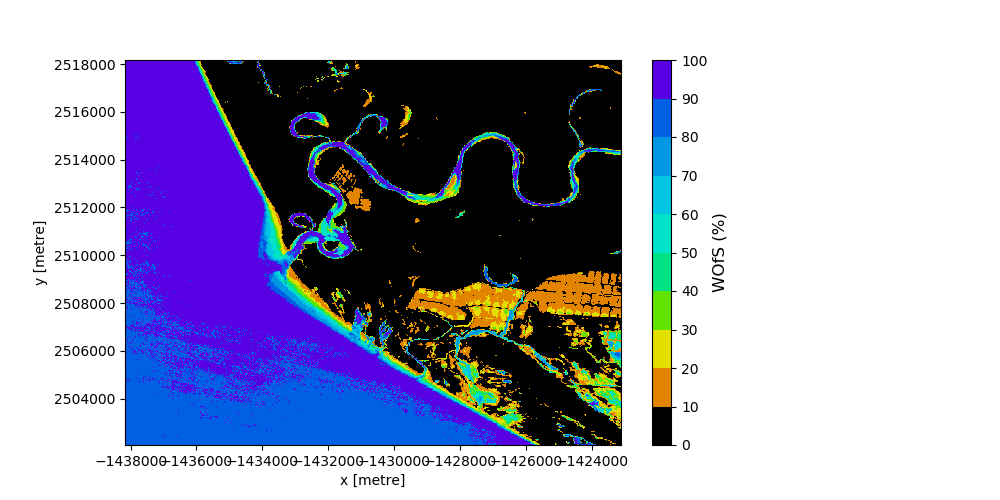

In [12]:
#Create WOfS image with specified colour ramp details
fig = plt.figure(figsize =(10,5)) 
i=wofs_percent.plot.imshow(cmap = wofs_cmap,norm=wofs_norm,vmin = 0, vmax = 100)
plt.colorbar(i, ticks=wofs_bounds, 
            ).set_label(label='WOfS (%)',
             size=12) #Add definable colour bar
fig.delaxes(fig.axes[1]) #Remove pre-defined colour bar

plt.show() #Create image